<a href="https://colab.research.google.com/github/sourabhkmr/Personal-Projects/blob/main/EMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import pywt

deltaT = 0.001
maxmin_count = 0
total_env_points = 10
mean_IMF = 1
iter = 0
nu = 0.5

f1 = 8
f2 = 24
f3 = 30
total_time = 2
time = np.arange(0, total_time + deltaT, deltaT)

sig1 = np.sin(2 * np.pi * f1 * time)
sig2 = np.sin(2 * np.pi * f2 * time)
sig3 = np.sin(2 * np.pi * f3 * time)
signal = 0.7*sig1 + 0.7*sig2 + 1.4*sig3





import pandas as pd
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib.pyplot as plt

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link2010 = 'https://drive.google.com/file/d/1yQ2GtRK65PK4bUcxPvRiu7GuzHwMpp0c/view?usp=sharing'
link2011 = 'https://drive.google.com/file/d/1Qx1Btu_MmD7ngu9eP5MICZsFfyRNHZAk/view?usp=sharing'
link2012 = 'https://drive.google.com/file/d/1SBiIAJF9oBNnHe6TQkZOIdzCvG3FjpEc/view?usp=sharing'
id = []
id = (link2010.split('/'))

file_id = id[5]

downloaded = drive.CreateFile({'id':file_id})
downloaded.GetContentFile('2459610_40.48_-69.22_2010.csv')
df = pd.read_csv('2459610_40.48_-69.22_2010.csv', skiprows = [0])
df.head()

wind_data = df['wind speed at 100m (m/s)']
signal = wind_data
deltaT = 5


signal = 0.7*sig1 + 0.7*sig2 + 1.4*sig3
IMF = []

L = len(signal)

sig_mean = np.mean(signal)
sig_without_mean = signal - sig_mean
sig_ext = pywt.pad(sig_without_mean,(nu*L,nu*L),'antireflect')

chi = []
L_s = len(sig_ext)

for x in range(L_s):
  if x < nu*L-1:
    chi.append(1/2*(np.cos(x*np.pi/nu/L-np.pi)+1))
  elif x < nu*L+L-1:
    chi.append(1)
  else:
    chi.append(1/2*(np.cos((L_s-x-1)*np.pi/nu/L-np.pi)+1))

chi_array = np.asarray(chi)

sig_mod = chi_array * sig_ext + sig_mean

c = sig_mod

x_coord = np.arange(0, len(sig_mod), 1)

curr_sig = signal

while total_env_points > 2:

    #sig_mean = np.mean(curr_sig)
    #sig_without_mean = curr_sig - sig_mean
    #sig_ext = pywt.pad(sig_without_mean,(L,L),'antireflect')

    #chi = []
    #L_s = len(sig_ext)

    #for x in range(L_s):
        #if x < L-1:
            #chi.append(1/2*(np.cos(x*np.pi/L-np.pi)+1))
        #elif x < 2 * L-1:
            #chi.append(1)
        #else:
            #chi.append(1/2*(np.cos((L_s-x-1)*np.pi/L-np.pi)+1))

    #chi_array = np.asarray(chi)
    #sig_mod = chi_array * sig_ext + sig_mean

    #c = sig_mod

    #x_coord = np.arange(0, len(sig_mod), 1)

    h = c
    total_std_dev = 1
    iter = 0

    while total_std_dev > 0.1 and iter < 50:

        location = []
        maxima_location = []
        minima_location = []
        maxima_points = []
        minima_points = []
        maxima_time = []
        minima_time = []

        maxima_location.append(0)
        minima_location.append(0)

        minima_total = 0
        maxima_total = 0
        zerocrossing_count = 0

        d = np.diff(h)

        i = 0

        for x in range(len(h)-2):
            if np.sign(d[x]) != np.sign(d[x+1]):
                maxmin_count += 1
                location.append(x+1)
                i += 1

        location_array = np.asarray(location)

        i = location_array[0]
        j = location_array[1]

        if h[i] > h[j]:
            count = 0
            while count < len(location_array)-1:
                maxima_location.append(location_array[count])
                minima_location.append(location_array[count+1])
                count += 2
        else:
            count = 0
            while count < len(location_array)-1:
                maxima_location.append(location_array[count+1])
                minima_location.append(location_array[count])
                count += 2

        maxima_location.append(len(h)-1)
        minima_location.append(len(h)-1)

        maxima_location_array = np.asarray(maxima_location)
        minima_location_array = np.asarray(minima_location)

        for x in range(len(maxima_location_array)):
            i = maxima_location_array[x]
            maxima_points.append(h[i])
            maxima_time.append(x_coord[i])

        for x in range(len(minima_location_array)):
            i = minima_location_array[x]
            minima_points.append(h[i])
            minima_time.append(x_coord[i])

        maxima_points_array = np.asarray(maxima_points)
        minima_points_array = np.asarray(minima_points)
        maxima_time_array = np.asarray(maxima_time)
        minima_time_array = np.asarray(minima_time)

        cs_maxima = CubicSpline(maxima_time_array, maxima_points_array)
        cs_minima = CubicSpline(minima_time_array, minima_points_array)

        max_env = cs_maxima(x_coord)
        min_env = cs_minima(x_coord)

        mean = np.zeros(len(max_env))
        for x in range(len(max_env)):
            mean[x] = 0.5 * (max_env[x] + min_env[x])

        mode = h - mean
        prevh = h

        maxima_total = len(maxima_points_array) - 2
        minima_total = len(minima_points_array) - 2
        mean_IMF = np.mean(mode)

        total_std_dev = 0
        for x in range(len(h)):
            std_dev = ((prevh[x]-mode[x])**2) / (prevh[x]**2 + 0.000001)
            total_std_dev += std_dev

        h = mode
        iter += 1

        print(iter, maxima_total, minima_total, mean_IMF, total_std_dev)

    IMF.append(h)
    c = c - h
    total_env_points = maxima_total + minima_total

    #for x in range(L):
        #curr_sig[x] = c[x+L]

IMF_array = np.asarray(IMF)
print(len(IMF_array))

1 120 120 -3.547385940216946e-16 863439.1696163692
2 120 120 -1.220940092064656e-16 124.9006954011507
3 120 120 -1.8735880685501267e-16 65.41523726495937
4 120 120 -2.5972725594829954e-16 57.38925689371371
5 120 120 -2.730466024071867e-16 8.635164490671263
6 120 120 -5.460932048143734e-17 9.047813436308504
7 120 120 -1.2076207456057688e-16 38.81203532484368
8 120 120 -1.4473689818657378e-16 53.300820720975764
9 120 120 -1.402971160336114e-16 9.616988037159233
10 120 120 -1.5805624464546092e-16 6.598007763812933
11 120 120 -1.4562485461716625e-16 1.9883860106275288
12 120 120 -1.3630131209594525e-16 1.4774035799289886
13 120 120 -1.2964163886650166e-16 1.2672185891515841
14 120 120 -1.287536824359092e-16 1.1138344838698528
15 120 120 -2.3841630161408013e-16 2.8820902945251157
16 120 120 -1.2431390028294679e-16 1.3551192560029046
17 120 120 -1.185421834840957e-16 1.080655246126616
18 120 120 -1.185421834840957e-16 1.3933042442939538
19 120 120 -1.2031809634528064e-16 2.864189258341728
20

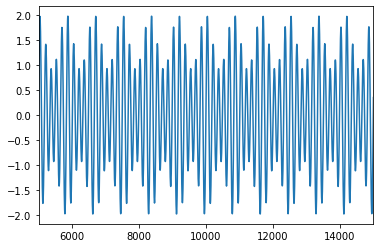

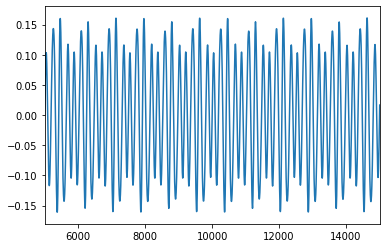

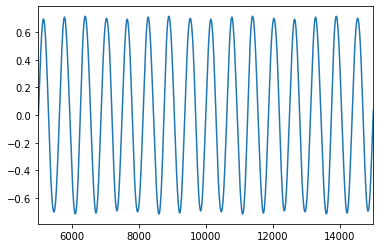

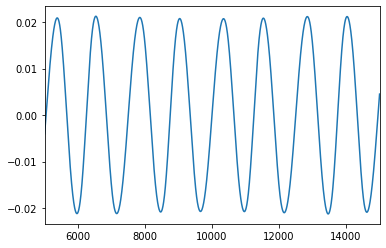

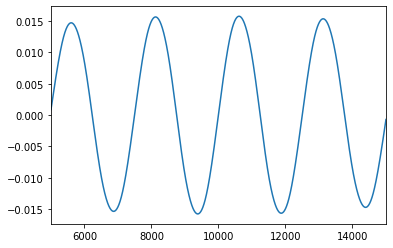

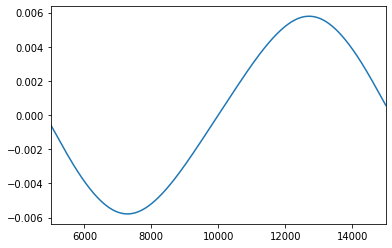

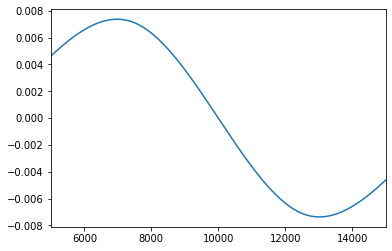

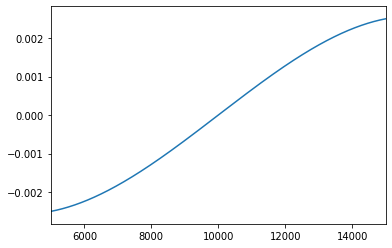

In [ ]:
time_mod = x_coord * deltaT
xlim_min = nu * L * deltaT
xlim_max = (nu * L + L - 1) * deltaT
for x in range(len(IMF_array)):
  plt.plot(time_mod, IMF_array[x,:])
  plt.xlim(xlim_min,xlim_max)
  plt.show()
  plt.close()

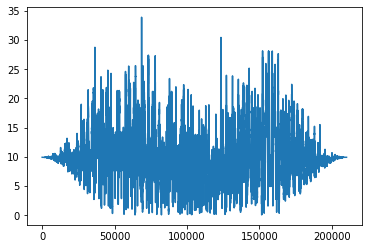

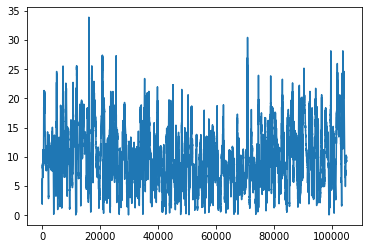

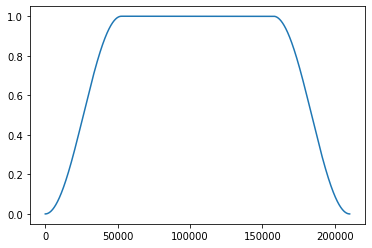

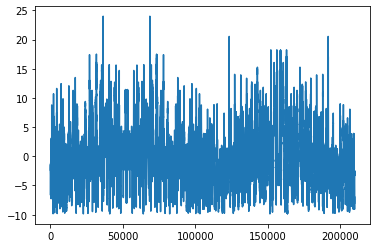

In [ ]:
#import pywt

#L = len(signal)
#sig_mean = np.mean(signal)
#sig_without_mean = signal - sig_mean
#sig_ext = pywt.pad(sig_without_mean,(L,L),'antireflect')

#chi = []
#L_s = len(sig_ext)

#for x in range(L_s):
  #if x < L-1:
    #chi.append(1/2*(np.cos(x*np.pi/L-np.pi)+1))
  #elif x < 2 * L-1:
    #chi.append(1)
  #else:
    #chi.append(1/2*(np.cos((L_s-x-1)*np.pi/L-np.pi)+1))

#chi_array = np.asarray(chi)

#sig_mod = chi_array * sig_ext + sig_mean


sig_mean = np.mean(signal)
sig_without_mean = signal - sig_mean
sig_ext = pywt.pad(sig_without_mean,(nu*L,nu*L),'symmetric')

chi = []
L_s = len(sig_ext)

for x in range(L_s):
  if x < nu*L-1:
    chi.append(1/2*(np.cos(x*np.pi/nu/L-np.pi)+1))
  elif x < nu*L+L-1:
    chi.append(1)
  else:
    chi.append(1/2*(np.cos((L_s-x-1)*np.pi/nu/L-np.pi)+1))

chi_array = np.asarray(chi)

sig_mod = chi_array * sig_ext + sig_mean



c = sig_mod
plt.plot(sig_mod)
plt.show()
plt.close()

plt.plot(signal)
plt.show()
plt.close()

plt.plot(chi_array)
plt.show()
plt.close()

plt.plot(sig_ext)
plt.show()
plt.close()


105120


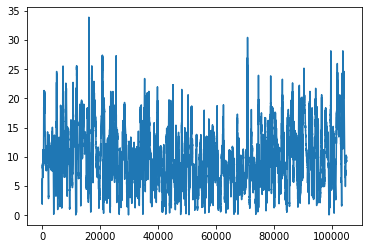

1

In [ ]:
import pandas as pd
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import matplotlib.pyplot as plt

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link2010 = 'https://drive.google.com/file/d/1yQ2GtRK65PK4bUcxPvRiu7GuzHwMpp0c/view?usp=sharing'
link2011 = 'https://drive.google.com/file/d/1Qx1Btu_MmD7ngu9eP5MICZsFfyRNHZAk/view?usp=sharing'
link2012 = 'https://drive.google.com/file/d/1SBiIAJF9oBNnHe6TQkZOIdzCvG3FjpEc/view?usp=sharing'
id = []
id = (link2010.split('/'))

file_id = id[5]

downloaded = drive.CreateFile({'id':file_id})
downloaded.GetContentFile('2459610_40.48_-69.22_2010.csv')
df = pd.read_csv('2459610_40.48_-69.22_2010.csv', skiprows = [0])
df.head()

wind_data = df['wind speed at 100m (m/s)']
print(len(wind_data))
plt.plot(wind_data)
plt.show()

1%12

In [ ]:
import sys
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import pywt
import statistics

deltaT = 0.001
maxmin_count = 0
total_env_points = 10
mean_IMF = 1
iter = 0
nu = 1

f1 = 8
f2 = 24
f3 = 30
total_time = 2
time = np.arange(0, total_time + deltaT, deltaT)

sig1 = np.sin(2 * np.pi * f1 * time)
sig2 = np.sin(2 * np.pi * f2 * time)
sig3 = np.sin(2 * np.pi * f3 * time)
signal = 0.7*sig1# + 0.7*sig2 + 1.4*sig3

prop = np.abs(np.max(signal) - np.min(signal))

std_dev = statistics.pstdev(signal)

NPstd = np.std(signal)

print(0.05*prop,0.2*std_dev,0.2*NPstd)

for x in range(10):
  print(np.random.normal(loc = 0,scale = std_dev,size = 5))

0.06999447309426714 0.09897020990568635 0.09897020990568633
[ 0.30917731  0.66972573 -0.61151344 -0.27457645 -0.94648251]
[ 0.9966584   0.31628689 -0.33789321 -0.24167689  0.1179413 ]
[ 0.22238956  1.20567978  0.57754557 -0.16185881  0.3469306 ]
[ 3.58020069e-01  1.85451282e-01  1.78534044e-01 -1.19793449e-04
  1.66880673e-01]
[-0.01113488 -0.96721643 -0.2204256  -0.51532367 -0.34090511]
[ 0.36686116 -0.33746674  0.44499504  0.74195202  0.64510392]
[-0.03035692  0.27561837  0.12347874  0.26173379 -0.60451433]
[ 0.97019008 -0.3763026   0.32967707 -0.57877558 -0.11307885]
[ 0.21155045 -0.45571078 -0.59980394  0.014106    0.6547364 ]
[-0.34401096  0.10548575 -0.13722485 -0.59203599 -0.23271711]


In [ ]:
import numpy as np

np.random.seed(1345)
for x in range(10):
  print(np.random.normal(0,std_dev,5))

[ 0.07494272 -1.30047682 -1.39682372  0.86109324 -0.28368948]
[-1.55990761  1.34692892 -0.19333299 -0.17021939  0.13717321]
[-0.88230984  0.77787478 -0.84817693  1.23222545 -0.56499068]
[-1.08946251  1.03426457 -0.17004401  0.14714922 -0.84204287]
[-0.26937746 -0.00564726 -2.06492268 -0.58666036  0.46762987]
[-0.05297922 -1.48112436 -2.01375016 -1.51372684  0.1252701 ]
[ 0.35431895 -1.06026487  1.47821405 -0.57096939 -0.2860174 ]
[1.2885171  0.27367922 0.93577216 0.85611818 0.45111769]
[ 0.97872714 -0.29890522  0.61488979 -1.53726959 -0.39723735]
[ 1.69388645  0.75350407  1.64126931 -1.88439166  0.8691929 ]
